In [1]:
import torch
import tqdm
from transformers import AutoTokenizer
from transformers.models.llama import LlamaForCausalLM
from transformers.models.llama.modeling_llama import LlamaMLP
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR
from datasets import load_dataset
from model import *
import gc

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-04-04 07:50:16.862909: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPT

In [8]:
from model import *


In [2]:
dtype = torch.bfloat16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-Instruct")
tokenizer.pad_token = tokenizer.eos_token
base_model = LlamaForCausalLM.from_pretrained("unsloth/Llama-3.2-1B-Instruct", torch_dtype=dtype)
base_model.to(device)
base_model.eval()

speculator_head = PredictorHead(base_model.model.config)
# speculator_head.load_state_dict(torch.load("speculator_head.pth", weights_only=True))
speculator_head.to(device, dtype=dtype)
specModel = TwoHeadModel(base_model, speculator_head)
specModel.to(device, dtype=dtype)
for param in specModel.base_model.parameters():
    param.requires_grad = False
for param in specModel.main_head.parameters():
    param.requires_grad = False



In [3]:
dataset = load_dataset("Aeala/ShareGPT_Vicuna_unfiltered", split="train[:50000]")

def tokenize_function(batch):
    conversations = batch["conversations"]
    texts = ["\n".join([turn["value"] for turn in convo]) for convo in conversations]
    tokenized = tokenizer(texts, truncation=True, max_length=128)
    return tokenized

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names)
tokenized_dataset = tokenized_dataset.filter(lambda x: len(x["input_ids"]) > 2)

def collate_fn(batch):
    input_ids = [example["input_ids"] for example in batch]
    padded = tokenizer.pad({"input_ids": input_ids}, return_tensors="pt")
    return padded

batch_size = 8
dataloader = DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
num_params = sum(p.numel() for p in specModel.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params / 1e6:.2f}M")


Number of parameters: 313.03M


In [10]:
# torch.save(specModel.speculator_head.state_dict(), "speculator_head1.pth")


In [4]:
speculator_head.load_state_dict(torch.load("speculator_head1.pth", weights_only=True))


<All keys matched successfully>

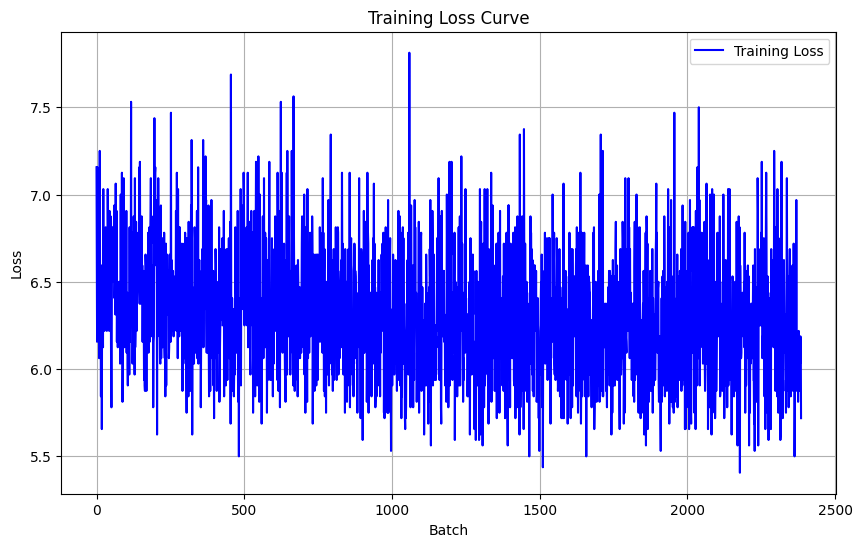

 38%|███▊      | 2386/6250 [1:13:28<2:01:12,  1.88s/it]/tmp/ipykernel_4141/234800523.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = loss_fn(spec_logits, torch.nn.functional.softmax(head_logits))
 38%|███▊      | 2387/6250 [1:13:30<2:00:04,  1.86s/it]

Epoch: 0 | Loss: 6.4688 | Avg Last 5 Loss: 6.1125


/tmp/ipykernel_4141/234800523.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = loss_fn(spec_logits, torch.nn.functional.softmax(head_logits))
 38%|███▊      | 2388/6250 [1:13:32<1:59:14,  1.85s/it]

Epoch: 0 | Loss: 5.9375 | Avg Last 5 Loss: 6.0938


/tmp/ipykernel_4141/234800523.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = loss_fn(spec_logits, torch.nn.functional.softmax(head_logits))
 38%|███▊      | 2389/6250 [1:13:34<1:58:36,  1.84s/it]

Epoch: 0 | Loss: 6.4688 | Avg Last 5 Loss: 6.1500


/tmp/ipykernel_4141/234800523.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = loss_fn(spec_logits, torch.nn.functional.softmax(head_logits))
 38%|███▊      | 2390/6250 [1:13:35<1:57:46,  1.83s/it]

Epoch: 0 | Loss: 6.9375 | Avg Last 5 Loss: 6.3063


/tmp/ipykernel_4141/234800523.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = loss_fn(spec_logits, torch.nn.functional.softmax(head_logits))
 38%|███▊      | 2391/6250 [1:13:37<1:57:22,  1.82s/it]

Epoch: 0 | Loss: 6.2812 | Avg Last 5 Loss: 6.4188


/tmp/ipykernel_4141/234800523.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = loss_fn(spec_logits, torch.nn.functional.softmax(head_logits))
 38%|███▊      | 2392/6250 [1:13:39<1:57:10,  1.82s/it]

Epoch: 0 | Loss: 6.6875 | Avg Last 5 Loss: 6.4625


/tmp/ipykernel_4141/234800523.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = loss_fn(spec_logits, torch.nn.functional.softmax(head_logits))
 38%|███▊      | 2393/6250 [1:13:41<1:56:56,  1.82s/it]

Epoch: 0 | Loss: 5.9688 | Avg Last 5 Loss: 6.4688


/tmp/ipykernel_4141/234800523.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = loss_fn(spec_logits, torch.nn.functional.softmax(head_logits))
 38%|███▊      | 2394/6250 [1:13:43<1:56:56,  1.82s/it]

Epoch: 0 | Loss: 5.9375 | Avg Last 5 Loss: 6.3625


/tmp/ipykernel_4141/234800523.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = loss_fn(spec_logits, torch.nn.functional.softmax(head_logits))
 38%|███▊      | 2395/6250 [1:13:44<1:56:51,  1.82s/it]

Epoch: 0 | Loss: 6.6250 | Avg Last 5 Loss: 6.3000


/tmp/ipykernel_4141/234800523.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = loss_fn(spec_logits, torch.nn.functional.softmax(head_logits))
 38%|███▊      | 2396/6250 [1:13:46<1:56:41,  1.82s/it]

Epoch: 0 | Loss: 7.3750 | Avg Last 5 Loss: 6.5187


/tmp/ipykernel_4141/234800523.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = loss_fn(spec_logits, torch.nn.functional.softmax(head_logits))
 38%|███▊      | 2397/6250 [1:13:48<1:56:48,  1.82s/it]

Epoch: 0 | Loss: 6.1875 | Avg Last 5 Loss: 6.4188


/tmp/ipykernel_4141/234800523.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = loss_fn(spec_logits, torch.nn.functional.softmax(head_logits))
 38%|███▊      | 2398/6250 [1:13:50<1:57:02,  1.82s/it]

Epoch: 0 | Loss: 6.0938 | Avg Last 5 Loss: 6.4437


/tmp/ipykernel_4141/234800523.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = loss_fn(spec_logits, torch.nn.functional.softmax(head_logits))
 38%|███▊      | 2399/6250 [1:13:52<1:57:08,  1.83s/it]

Epoch: 0 | Loss: 5.7188 | Avg Last 5 Loss: 6.4000


/tmp/ipykernel_4141/234800523.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = loss_fn(spec_logits, torch.nn.functional.softmax(head_logits))
 38%|███▊      | 2399/6250 [1:13:53<1:58:36,  1.85s/it]


KeyboardInterrupt: 

In [20]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gc
import numpy as np
from torch.optim.lr_scheduler import LinearLR  # Corrected import

# Training setup
optimizer = torch.optim.Adam(speculator_head.parameters(), lr=3e-5)
loss_fn = torch.nn.CrossEntropyLoss()

num_epochs = 1  # adjust as needed
torch.cuda.empty_cache()
_ = gc.collect()

specModel.train()

total_steps = num_epochs * len(dataloader)  # Total training steps
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=total_steps)  # Linear decay from 1.0 to 0.1

# Loss tracking
loss_values = []
recent_losses = []

for epoch in range(num_epochs):
    idx = 0
    for batch in tqdm.tqdm(dataloader):
        input_ids = batch["input_ids"].to(device)

        head_logits, spec_logits = specModel(input_ids)
        head_logits = head_logits[:, 1:, :]
        spec_logits = spec_logits[:, :-1, :]

        head_logits = head_logits.reshape(-1, head_logits.shape[-1])
        spec_logits = spec_logits.reshape(-1, spec_logits.shape[-1])
        loss = loss_fn(spec_logits, torch.nn.functional.softmax(head_logits))

        # Update loss tracking
        loss_values.append(loss.item())
        recent_losses.append(loss.item())
        if len(recent_losses) > 5:
            recent_losses.pop(0)
        
        avg_recent_loss = np.mean(recent_losses)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        print(f"Epoch: {epoch} | Loss: {loss.item():.4f} | Avg Last 5 Loss: {avg_recent_loss:.4f}")

        # Live update of the plot every 10 batches
        if idx % 15 == 0:
            clear_output(True)
            fig, ax = plt.subplots(figsize=(10, 6))
            line, = ax.plot(range(len(loss_values)), loss_values, label="Training Loss", color="blue")
            ax.set_xlabel("Batch")
            ax.set_ylabel("Loss")
            ax.set_title("Training Loss Curve")
            ax.legend()
            ax.grid(True)
            ax.autoscale_view()
            # plt.
            plt.show()
            # plt.pause(0.1)  # Пауза для обновления графика    

        idx += 1
        if idx % 1000 == 0:
            # torch.save(specModel.speculator_head.state_dict(), "speculator_head1.pth")

# Save the final model
# torch.save(specModel.speculator_head.state_dict(), "speculator_head1.pth")

plt.show()  # Display final loss curve


In [ ]:
# for batch in tqdm.tqdm(dataloader):
#     input_ids = batch["input_ids"].to(device)

In [17]:
import torch.nn.functional as F

def compute_accuracy(model, dataloader, device):
    model.eval()
    agree = 0
    total = 0

    with torch.no_grad():
        idx = 0
        for batch in dataloader:
            
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            main_logits, spec_logits = model(input_ids, attention_mask)
            
            main_logits = main_logits[:, 1:, :]
            spec_logits = spec_logits[:, :-1, :]

            main_preds = torch.argmax(main_logits, dim=-1)
            spec_preds = torch.argmax(spec_logits, dim=-1)

            agree += (main_preds == spec_preds).sum().item()
            total += main_preds.numel()
            
            idx += 1
            if idx > 30:
                break

    return agree / total if total > 0 else 0

In [18]:
print(compute_accuracy(specModel, tqdm.tqdm(dataloader), device))

  0%|          | 30/6250 [00:35<2:01:25,  1.17s/it]

0.18713487426974854


In [16]:
batch = next(iter(tqdm.tqdm(dataloader)))

# print(batch['input_ids'].size(dim=0))
# print(batch['input_ids'].size(dim=1))
specModel.eval()

input_ids = batch["input_ids"].to(device)
attention_mask = batch["attention_mask"].to(device)
main_logits, spec_logits = specModel(input_ids, attention_mask)

print(main_logits.size())
print(spec_logits.size())

  0%|          | 0/6250 [00:00<?, ?it/s]

torch.Size([8, 128, 128256])
torch.Size([8, 128, 128256])
